In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
import os
import sys
import json
import time
from datetime import datetime
import numpy as np
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
from collections import OrderedDict
import seaborn as sns
%matplotlib inline


In [41]:
lineage_order = ["driver::send", 
                     "clipper::frontend_rpc_recv", 
                     "clipper::task_enqueued", 
                     "clipper::task_dequeued", 
                     "clipper::sent_rpc", 
                     "container::recv",
                     "container::send", 
                     "clipper::rpc_recv", 
                     "clipper::task_executor_recv",
                     "clipper::task_executor_recv_end",
                     "clipper::task_executor_msg_callback_found",
                     "clipper::zmq_frontend_response_callback", 
                     "clipper::frontend_rpc_response_send", 
                     "driver::recv"]

def extract_lineage_deltas(lineage):
    first_key = "driver::send"

    extracted = {k: [] for k in lineage_order}
    for entry in lineage:
        for i in range(1,len(lineage_order)):
            try:
                k = lineage_order[i]
            
                previous_timestamp = entry[lineage_order[i-1]]
            
                delta = entry[k] - previous_timestamp
                extracted[k].append(float(delta) / 1000.0)
            except KeyError as e:
                print("CCCCCCCCCCCCCCCCCCC")
    return extracted



def plot_comparison(path):

    snp_lineages = {}
    for fpath in os.listdir(path):
        core = int(fpath.split("-")[7])
        with open(os.path.join(path, fpath), "r") as f:
            results = json.load(f)
            snp_lineages[core] = results["throughput_results"]["lineage"][1000:]

    snp_deltas = {core : extract_lineage_deltas(l) for core, l in snp_lineages.items()}
    deltas = snp_deltas
    colors = sns.color_palette("cubehelix", 8)
    point = "container::send"
    fig, (ax_scatter, ax_hist, ax_box) = plt.subplots(ncols=3, figsize=(20,6))
    dists = []
    for core in range(len(snp_deltas)):
        extracted_lineage = deltas[core]
        print(core)
        v = extracted_lineage[point]
        if len(v) > 0:
            print(np.mean(v), np.percentile(v, 99))
            ax_scatter.scatter(np.arange(len(v)), v, alpha = 0.4, label=str(core), color=colors[core])
            ax_hist.hist(v, 100, label=str(core), normed=True, histtype='bar', color=colors[core], cumulative=False, log=True)
            dists.append(v)
    ax_box.boxplot(x=dists, positions=range(len(dists)), vert=True)
    ax_box.set_ylabel("Time (ms)")
    ax_box.set_xlabel("GPU number")
    ax_scatter.set_ylabel("Time (ms)")
    ax_scatter.legend(loc=0, ncol=4, mode="expand")
    ax_hist.legend(loc=0)   
    xmax = ax_hist.get_xlim()[1]
    ax_hist.set_xlim(right=max(10, xmax))
    ax_hist.set_xlabel("Time (ms)")
    ax_hist.set_ylabel("Query ID")
    ax_hist.set_ylabel("Count (normalized)")
    ax_hist.grid(b=True, which="both")
    #         ax_box.legend(loc=0)
    fig.suptitle(point, fontsize=20)
    plt.savefig("gpu_assignment.pdf")
    plt.show()

# p3.8xlarge: No disparity in perf between GPUs

0
255.191821008 270.013
1
255.229464279 261.266
2
256.090291466 266.581
3
255.110720114 265.893


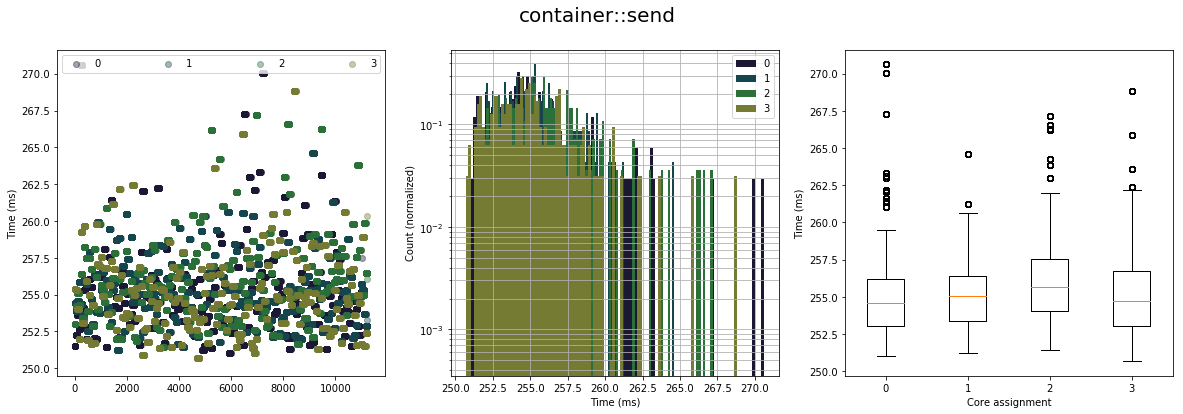

In [38]:
path = "../results_cpp_benchmarker/query_lineage/tf-resnet-feats-snp-resource-placement-debugging-gpu-v100-batch-64/"
plot_comparison(path)

# p2.8xlarge: Even numbered GPUs are significantly faster

0
639.7139002 649.146
1
664.386538064 673.728
2
648.2486975 657.351
3
663.902946257 674.437
4
647.494788584 657.85
5
670.48636248 680.053
6
647.590282762 658.289
7
677.240180986 688.824


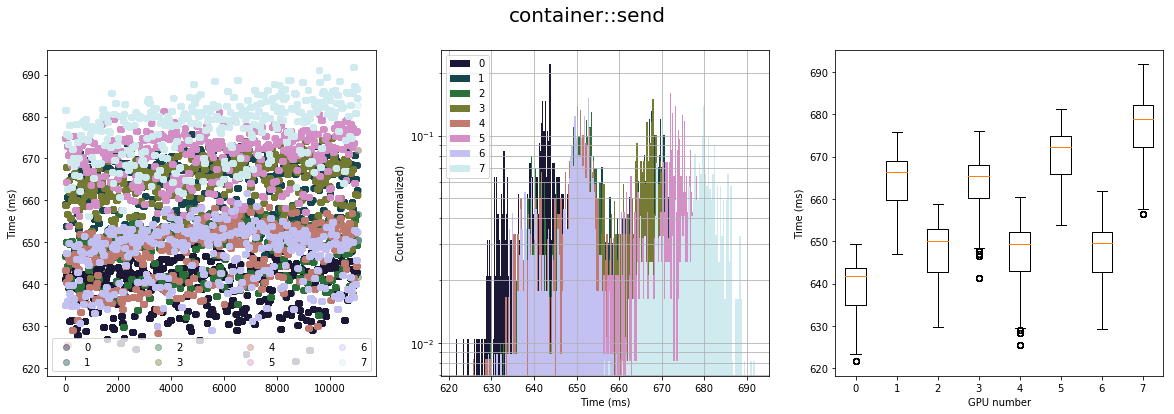

In [42]:
path = "../results_cpp_benchmarker/query_lineage/tf-resnet-feats-snp-resource-placement-debugging-gpu-k80-batch-32/"
plot_comparison(path)

# p2.8xlarge: replication on new machine

0
646.935763679 655.081
1
663.633845574 673.735
2
642.963381004 651.019
3
664.85842505 674.735
4
645.474902846 655.21
5
667.456493274 677.265
6
648.765967279 657.316
7
666.265048628 676.456


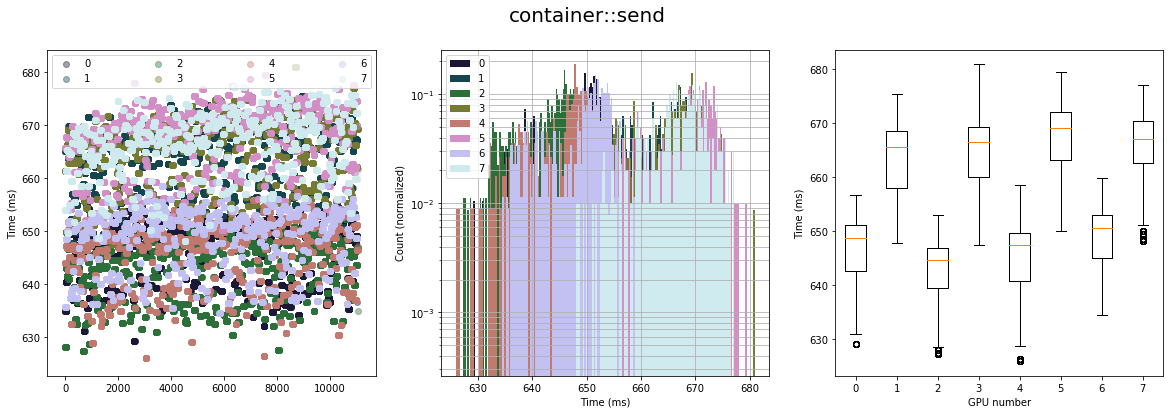

In [43]:
path = "../results_cpp_benchmarker/query_lineage/tf-resnet-feats-snp-resource-placement-debugging-gpu-k80-batch-32-machine2"
plot_comparison(path)